In [1]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import snippets as sp
reload(sp)

<module 'snippets' from '/gpfs/home/mep22dku/scratch/SOZONE/UTILS/snippets.py'>

## check and make gcb 2025 forcing

       year      co2     co2a
0  1700.042  278.423  277.573
1  1700.125  278.740  277.574
2  1700.208  279.037  277.574
3  1700.292  279.298  277.575
4  1700.375  279.174  277.576


<AxesSubplot:xlabel='year'>

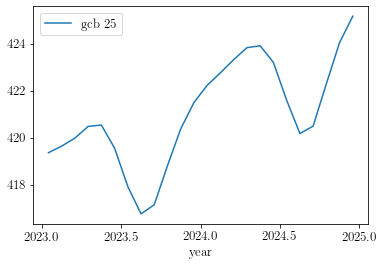

In [2]:
gcb25 = pd.read_csv('./Atm_CO2_forcing.csv')
gcb25 = gcb25.rename(columns={"Year_Decimal": "year", "CO2_ppm": "co2", "CO2_ppm.trend": "co2a"})
print(gcb25.head())
df = gcb25
df_filtered = df[(df['year'] > 2023) & (df['year'] < 2025)]
df_filtered.plot(x='year', y='co2', linestyle='-', label = 'gcb 25')

In [3]:
df1 = pd.read_csv("/gpfs/home/mep22dku/scratch/GCB2023_atmco2/gcbco2_2024_4200_v2_padding.dat",\
                    delim_whitespace=True, header=None, names=["year", "co2", "co2a", "que"])

gcb25 = pd.read_csv('./Atm_CO2_forcing.csv')

# Display the first few rows
df2 = gcb25.rename(columns={"Year_Decimal": "year", "CO2_ppm": "co2", "CO2_ppm.trend": "co2a"})


# Remove 2010-2026 data from df1
df1_filtered = df1[~df1['year'].between(2010, 2026)]

# Select 2010-2026 data from df2
df2_filtered = df2[df2['year'].between(2010, 2026)]

# Concatenate the dataframes
df_final = pd.concat([df1_filtered, df2_filtered])

# Sort by year
df_final = df_final.sort_values(by='year').reset_index(drop=True)

(409.0, 428.0)

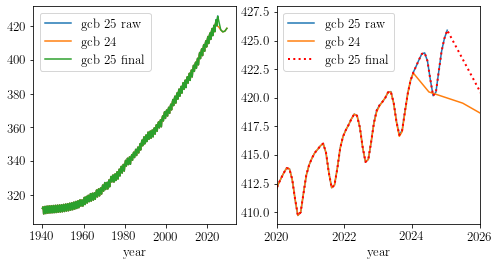

In [4]:

fact = 0.5
fig, axs = plt.subplots(1,2, figsize=(16*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

df = df2
df_filtered = df[(df['year'] > 1940) & (df['year'] < 2030)]
df_filtered.plot(x='year', y='co2', linestyle='-', ax = axs[0], label = 'gcb 25 raw')

df = df1
df_filtered = df[(df['year'] > 1940) & (df['year'] < 2030)]
df_filtered.plot(x='year', y='co2', linestyle='-', ax = axs[0], label = 'gcb 24')

df = df_final
df_filtered = df[(df['year'] > 1940) & (df['year'] < 2030)]
df_filtered.plot(x='year', y='co2', linestyle='-', ax = axs[0], label = 'gcb 25 final')


df = df2
df_filtered = df[(df['year'] > 1940) & (df['year'] < 2030)]
df_filtered.plot(x='year', y='co2', linestyle='-', ax = axs[1], label = 'gcb 25 raw')

df = df1
df_filtered = df[(df['year'] > 1940) & (df['year'] < 2030)]
df_filtered.plot(x='year', y='co2', linestyle='-', ax = axs[1], label = 'gcb 24')

df = df_final
df_filtered = df[(df['year'] > 1940) & (df['year'] < 2030)]
df_filtered.plot(x='year', y='co2', linestyle=':', color = 'r', linewidth = 2,\
                 ax = axs[1], label = 'gcb 25 final')


axs[1].set_xlim([2020,2026])
axs[1].set_ylim([409,428])

In [5]:
df_final['que'] = df_final['que'].fillna(1796.3)

In [6]:
save = False
if save:
    df_final.to_csv("/gpfs/data/greenocean/software/resources/SOZONE_atmo/GCB2025/gcbco2_2025_1650-2497.dat", 
                       sep="\t", 
                       index=False, 
                       header=False, 
                       float_format="%.6f")

In [7]:
#1796.300000

In [8]:
ist = 4490; ie = ist+20
df_final[ist:ie]

,year,co2,co2a,que
4490,2024.208,423.340,421.73,1796.3
4491,2024.292,423.850,422.04,1796.3
4492,2024.375,423.930,422.32,1796.3
4493,2024.458,423.220,422.67,1796.3
4494,2024.542,421.600,422.94,1796.3
4495,2024.625,420.190,423.08,1796.3
4496,2024.708,420.500,423.35,1796.3
4497,2024.792,422.320,423.81,1796.3
4498,2024.875,424.070,424.16,1796.3
4499,2024.958,425.190,424.50,1796.3


In [9]:
import os
import shutil
from pathlib import Path
import glob

def move_and_symlink(exp_name="exp1", exp_name2="exp1", typ = 'ptrc', yr1 = 1940, yr2 = 2020):

    dir1 = f'/gpfs/data/greenocean/software/runs/{exp_name}'
    dir2 = f'/gpfs/data/greenocean/software/runs/{exp_name2}'


    for yr in range(yr1, yr2):
        print(f'{yr} {typ}')
        source = glob.glob(f'{dir1}/ORCA2*1m_{yr}*{typ}*.nc')[0]
        dst = source.replace(f'{exp_name}', f'{exp_name2}') 
            
        try:
            os.symlink(source, dst)
            #print(f"Moved {source} -> {dst} and created symlink.")
        except:
            print(f"no for {source}")
            
typs = ['grid_T','diad_T','ptrc_T','icemod','grid_V']

# for typ in typs:
#     move_and_symlink(exp_name="TOM12_TJ_R4A1", exp_name2="TOM12_TJ_25A0", typ = typ)
#     move_and_symlink(exp_name="TOM12_TJ_R4B1", exp_name2="TOM12_TJ_25B0", typ = typ)
#     move_and_symlink(exp_name="TOM12_TJ_R4C1", exp_name2="TOM12_TJ_25C0", typ = typ)
#     move_and_symlink(exp_name="TOM12_TJ_R4D1", exp_name2="TOM12_TJ_25D0", typ = typ)

In [11]:
typs = ['grid_T','diad_T','ptrc_T','icemod','grid_V']



### intercompare scenario forcing and gcb forcing

In [2]:
#/gpfs/data/greenocean/software/resources/SOZONE_atmo/atmco2_ssp1-26.dat
#/gpfs/data/greenocean/software/resources/SOZONE_atmo/GCB2025/gcbco2_2025_1650-2600.dat

mh126 = pd.read_csv("/gpfs/data/greenocean/software/resources/SOZONE_atmo/atmco2_ssp1-26.dat",\
                    delim_whitespace=True, header=None, names=["year", "co2", "co2a", "que"])
mh370 = pd.read_csv("/gpfs/data/greenocean/software/resources/SOZONE_atmo/atmco2_ssp3-70.dat",\
                    delim_whitespace=True, header=None, names=["year", "co2", "co2a", "que"])
gcb25 = pd.read_csv("/gpfs/data/greenocean/software/resources/SOZONE_atmo/GCB2025/gcbco2_2025_1650-2600.dat",\
                    delim_whitespace=True, header=None, names=["year", "co2", "co2a", "que"])

realmh = pd.read_csv\
("/gpfs/data/greenocean/software/resources/SOZONE_atmo/meinshausen-2020.csv")
realmh.yr = realmh.yr+0.5

In [5]:
from datetime import datetime, timedelta

def decimal_year_to_datetime(decimal_year):
    """Convert a decimal year (e.g., 2000.5) to a NumPy datetime64[ns]."""
    year = np.floor(decimal_year).astype(int)
    remainder = decimal_year - year
    days_in_year = 365.25  # Average days per year

    # Convert to datetime64 format
    date = np.datetime64(f'{year}-01-01') + np.timedelta64(int(remainder * days_in_year), 'D')
    
    return date


In [6]:
# Convert decimal year to datetime (approximate)
mh126['datetime'] = mh126['year'].apply(decimal_year_to_datetime)
mh370['datetime'] = mh370['year'].apply(decimal_year_to_datetime)
gcb25['datetime'] = gcb25['year'].apply(decimal_year_to_datetime)
realmh['datetime'] = realmh['yr'].apply(decimal_year_to_datetime)
# Convert to xarray Dataset
mh126_xr = xr.Dataset(
    {'co2': (['time'], mh126['co2'].values)},
    coords={'time': mh126['datetime'].values})
mh370_xr = xr.Dataset(
    {'co2': (['time'], mh370['co2'].values)},
    coords={'time': mh370['datetime'].values})
gcb25_xr = xr.Dataset(
    {'co2': (['time'], gcb25['co2'].values)},
    coords={'time': gcb25['datetime'].values})

realmh126_xr = xr.Dataset(
    {'co2': (['time'], realmh['ssp1-2.6'].values)},
    coords={'time': realmh['datetime'].values})
realmh370_xr = xr.Dataset(
    {'co2': (['time'], realmh['ssp3-7.0'].values)},
    coords={'time': realmh['datetime'].values})

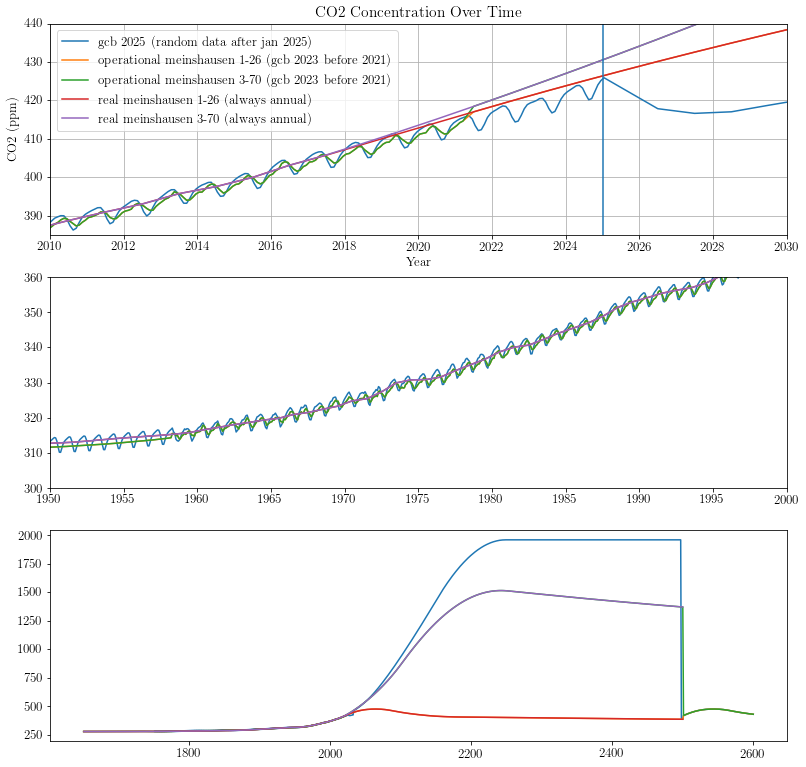

In [7]:
fact = 1.1
fig, axs = plt.subplots(3,1, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,3):
    axs[i].plot(gcb25_xr.time, gcb25_xr.co2, linestyle='-', label = 'gcb 2025 (random data after jan 2025)')
    axs[i].plot(mh126_xr.time, mh126_xr.co2, linestyle='-', label = 'operational meinshausen 1-26 (gcb 2023 before 2021)')
    axs[i].plot(mh370_xr.time, mh370_xr.co2, linestyle='-', label = 'operational meinshausen 3-70 (gcb 2023 before 2021)')
    axs[i].plot(realmh126_xr.time, realmh126_xr.co2, linestyle='-', label = 'real meinshausen 1-26 (always annual)')
    axs[i].plot(realmh370_xr.time, realmh370_xr.co2, linestyle='-', label = 'real meinshausen 3-70 (always annual)')


# Set x-axis limits
axs[0].set_xlim([datetime(2010, 1, 1), datetime(2030, 1, 1)])
axs[0].set_ylim([385,440])

# Improve readability
axs[0].set_title("CO2 Concentration Over Time")
axs[0].set_xlabel("Year")
axs[0].set_ylabel("CO2 (ppm)")
axs[0].grid(True)
axs[0].axvline(x = datetime(2025, 1, 1))
axs[0].legend(loc = 'best')

#Set x-axis limits
axs[1].set_xlim([datetime(1950, 1, 1), datetime(2000, 1, 1)])
axs[1].set_ylim([300,360])
# axs[0].set_ylim([365,440])



plt.show()

In [8]:
mh126_xr = mh126_xr.sel(time=(mh126_xr['time'] >= np.datetime64('1750-01-01')) &
                        (mh126_xr['time'] < np.datetime64('2101-01-01')))
mh370_xr = mh370_xr.sel(time=(mh370_xr['time'] >= np.datetime64('1750-01-01')) &
                        (mh370_xr['time'] < np.datetime64('2101-01-01')))
gcb25_xr = gcb25_xr.sel(time=(gcb25_xr['time'] >= np.datetime64('1750-01-01')) &
                        (gcb25_xr['time'] < np.datetime64('2101-01-01')))


mh126_xr['time'] = pd.to_datetime(mh126_xr['time'].values)
mh370_xr['time'] = pd.to_datetime(mh370_xr['time'].values)
gcb25_xr['time'] = pd.to_datetime(gcb25_xr['time'].values)

realmh126_xr = realmh126_xr.sel(time=(realmh126_xr['time'] >= np.datetime64('1750-01-01')) &
                        (realmh126_xr['time'] < np.datetime64('2101-01-01')))
realmh370_xr = realmh370_xr.sel(time=(realmh370_xr['time'] >= np.datetime64('1750-01-01')) &
                        (realmh370_xr['time'] < np.datetime64('2101-01-01')))

realmh126_xr['time'] = pd.to_datetime(realmh126_xr['time'].values)
realmh370_xr['time'] = pd.to_datetime(realmh370_xr['time'].values)


In [9]:
mh126_an = mh126_xr.resample(time='Y').mean()
mh370_an = mh370_xr.resample(time='Y').mean()
realmh126_an = realmh126_xr.resample(time='Y').mean()
realmh370_an = realmh370_xr.resample(time='Y').mean()
gcb25_an = gcb25_xr.resample(time='Y').mean()

In [10]:
co2_derivative = np.zeros_like(realmh126_an['co2'].values)  # Initialize an array with zeros
# Loop through each year starting from the second year
for i in range(1, len(realmh126_an['time'])):
    co2_derivative[i] = realmh126_an['co2'].values[i] - realmh126_an['co2'].values[i - 1]
realmh126_diff = xr.DataArray(co2_derivative, coords=[realmh126_an['time']], dims=["time"])
realmh126_diff = realmh126_diff.rename('co2_derivative')
 # Initialize an array with zeros

# Loop through each year starting from the second year
co2_derivative2 = np.zeros_like(realmh370_an['co2'].values) 
for i in range(1, len(realmh370_an['time'])):
    co2_derivative2[i] = realmh370_an['co2'].values[i] - realmh370_an['co2'].values[i - 1]
realmh370_diff = xr.DataArray(co2_derivative2, coords=[realmh370_an['time']], dims=["time"])
realmh370_diff = realmh370_diff.rename('co2_derivative')

co2_derivative3 = np.zeros_like(realmh370_an['co2'].values) 
# Loop through each year starting from the second year
for i in range(1, len(gcb25_an['time'])):
    co2_derivative3[i] = gcb25_an['co2'].values[i] - gcb25_an['co2'].values[i - 1]
gcb25_diff = xr.DataArray(co2_derivative3, coords=[gcb25_an['time']], dims=["time"])
gcb25_diff = gcb25_diff.rename('co2_derivative')

(360.0, 420.0)

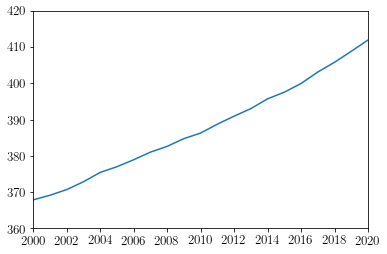

In [11]:
plt.plot(realmh370_an.time, realmh370_an.co2)
plt.xlim([datetime(2000, 1, 1), datetime(2020, 1, 1)])
plt.ylim([360,420])

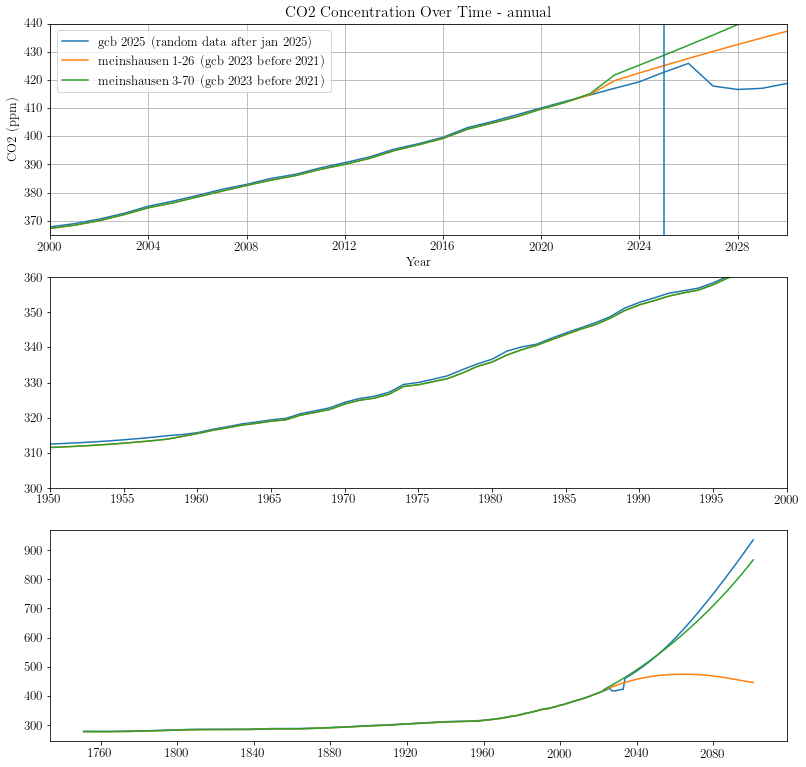

In [12]:
fig, axs = plt.subplots(3,1, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,3):
    axs[i].plot(gcb25_an.time, gcb25_an.co2, linestyle='-', label = 'gcb 2025 (random data after jan 2025)')
    axs[i].plot(mh126_an.time, mh126_an.co2, linestyle='-', label = 'meinshausen 1-26 (gcb 2023 before 2021)')
    axs[i].plot(mh370_an.time, mh370_an.co2, linestyle='-', label = 'meinshausen 3-70 (gcb 2023 before 2021)')

# Set x-axis limits
axs[0].set_xlim([datetime(2000, 1, 1), datetime(2030, 1, 1)])
axs[0].set_ylim([365,440])

# Improve readability
axs[0].set_title("CO2 Concentration Over Time - annual")
axs[0].set_xlabel("Year")
axs[0].set_ylabel("CO2 (ppm)")
axs[0].grid(True)
axs[0].axvline(x = datetime(2025, 1, 1))
axs[0].legend(loc = 'best')

#Set x-axis limits
axs[1].set_xlim([datetime(1950, 1, 1), datetime(2000, 1, 1)])
axs[1].set_ylim([300,360])
# axs[0].set_ylim([365,440])



plt.show()


In [13]:
max(realmh370_diff.values)

8.360000000000014

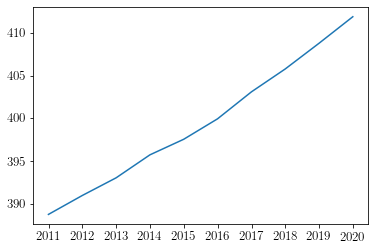

In [14]:
ind = 260; ofs = 10
plt.plot(realmh370_an.time[ind:ind+ofs], realmh370_an.co2[ind:ind+ofs])

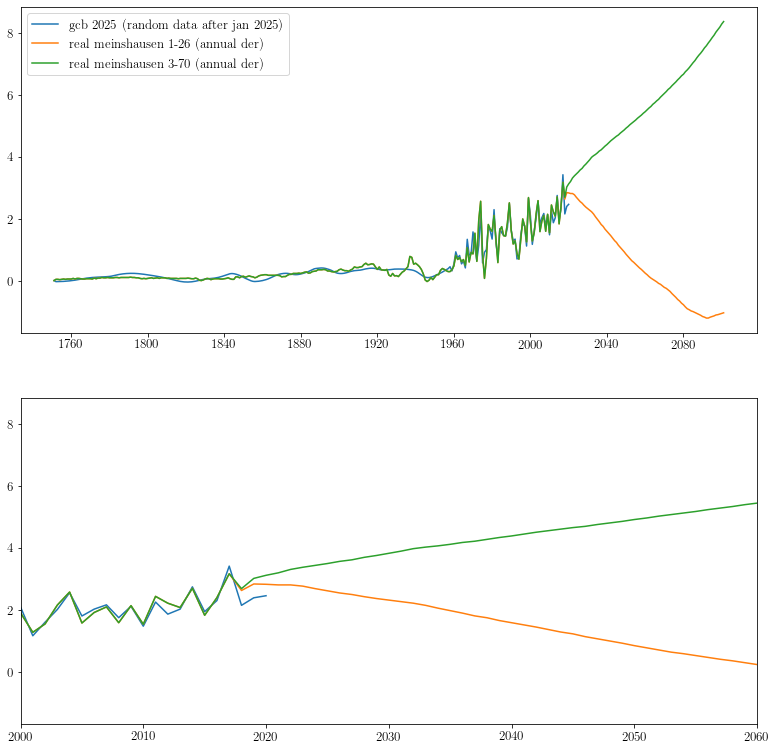

In [15]:
fig, axs = plt.subplots(2,1, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,2):
    axs[i].plot(gcb25_diff.time[0:270], gcb25_diff[0:270], linestyle='-', label = 'gcb 2025 (random data after jan 2025)')
    axs[i].plot(realmh126_diff.time, realmh126_diff, linestyle='-', label = 'real meinshausen 1-26 (annual der)')
    axs[i].plot(realmh370_diff.time, realmh370_diff, linestyle='-', label = 'real meinshausen 3-70 (annual der)')

# # Set x-axis limits
#axs[0].set_xlim([datetime(2030, 1, 1), datetime(2040, 1, 1)])

axs[0].legend(loc = 'best')

axs[1].set_xlim([datetime(2000, 1, 1), datetime(2060, 1, 1)])

# #Set x-axis limits
# axs[1].set_xlim([datetime(1950, 1, 1), datetime(2000, 1, 1)])
# # axs[1].set_ylim([300,360])
# # axs[0].set_ylim([365,440])



plt.show()


In [16]:
ind = 280
gcb25_an.co2[ind:ind+5]

<xarray.DataArray 'co2' (time: 5)>
array([420.36 , 421.57 , 422.16 , 459.964, 463.852])
Coordinates:
  * time     (time) datetime64[ns] 2030-12-31 2031-12-31 ... 2034-12-31

In [17]:



mh126_xr['time'] = mh126_xr['time'].astype('datetime64[ns]')
mh126_an = mh126_xr.resample(time='Y').mean()
# Resample by year and compute annual means
#ds_annual = ds.resample(time='Y').mean()

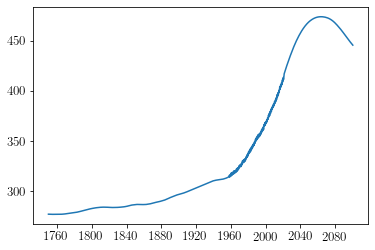

In [18]:
plt.plot(mh126_xr.time,mh126_xr.co2)

## create internally consistent forcing files

- currently the old scenario atmo co2 files are a bit of a stitch of gcb 2022 or so + meinshausen scenarios (which deoesn't really matter, differences are small); make it such that the past and future meinshausen are all annual-only, linearly interpolated between meinshausen originals. also update gcb25 file, and 

In [137]:
#/gpfs/data/greenocean/software/resources/SOZONE_atmo/atmco2_ssp1-26.dat
#/gpfs/data/greenocean/software/resources/SOZONE_atmo/GCB2025/gcbco2_2025_1650-2600.dat

mh126 = pd.read_csv("/gpfs/data/greenocean/software/resources/SOZONE_atmo/atmco2_ssp1-26.dat",\
                    delim_whitespace=True, header=None, names=["year", "co2", "co2a", "que"])
mh370 = pd.read_csv("/gpfs/data/greenocean/software/resources/SOZONE_atmo/atmco2_ssp3-70.dat",\
                    delim_whitespace=True, header=None, names=["year", "co2", "co2a", "que"])
gcb25 = pd.read_csv("/gpfs/data/greenocean/software/resources/SOZONE_atmo/GCB2025/gcbco2_2025_1650-2600.dat",\
                    delim_whitespace=True, header=None, names=["year", "co2", "co2a", "que"])
gcb25_short = pd.read_csv("/gpfs/data/greenocean/software/resources/SOZONE_atmo/GCB2025/gcbco2_2025_1650-2497.dat",\
                          delim_whitespace=True, header=None, names=["year", "co2", "co2a", "que"])

realmh = pd.read_csv\
("/gpfs/data/greenocean/software/resources/SOZONE_atmo/meinshausen-2020.csv")
realmh = realmh.rename(columns={'yr': 'year'})


## this way is dumb, let's interpolate instead

In [138]:

# year_to_value = realmh.set_index('year')['ssp3-7.0'].to_dict()
# # Floor the decimal years in mh370_an to get the base year
# mh370_an['base_year'] = mh370_an['year'].astype(int)
# # Map values from realmh using base_year
# mh370_an['co2'] = mh370_an['base_year'].map(year_to_value)
# # Drop base_year if you don't need it
# mh370_an = mh370_an.drop(columns='base_year')


# year_to_value2 = realmh.set_index('year')['ssp1-2.6'].to_dict()
# # Floor the decimal years in mh126_an to get the base year
# mh126_an['base_year'] = mh126_an['year'].astype(int)
# # Map values from realmh using base_year
# mh126_an['co2'] = mh126_an['base_year'].map(year_to_value2)
# # Drop base_year if you don't need it
# mh126_an = mh126_an.drop(columns='base_year')

# mh126_an['co2'] = mh126_an['co2'].ffill()
# mh370_an['co2'] = mh370_an['co2'].ffill()

save = False
if save:
    mh126_an.to_csv("/gpfs/data/greenocean/software/resources/SOZONE_atmo/atmco2_ssp1-26-meinshausen2020-annual.dat", 
                       sep="\t", 
                       index=False, 
                       header=False, 
                       float_format="%.6f")
    
    mh370_an.to_csv("/gpfs/data/greenocean/software/resources/SOZONE_atmo/atmco2_ssp3-70-meinshausen2020-annual.dat", 
                       sep="\t", 
                       index=False, 
                       header=False, 
                       float_format="%.6f")
    
# plt.figure()
# plt.plot(mh370_an.year, mh370_an.co2)
# plt.plot(mh126_an.year, mh126_an.co2)

# plt.xlim([1750,2100])
# plt.ylim([270,900])

## interpolation

(410.0, 420.0)

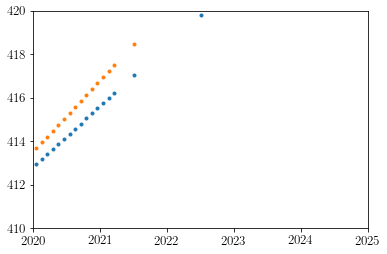

In [139]:
mh126_an = mh126.copy()
mh370_an = mh370.copy()
realmh = pd.read_csv\
("/gpfs/data/greenocean/software/resources/SOZONE_atmo/meinshausen-2020.csv")
realmh = realmh.rename(columns={'yr': 'year'})
realmh.year = realmh.year + 0.5


# # Known data points
x = realmh['year'].to_numpy()
y = realmh['ssp1-2.6'].to_numpy()
x_new = mh126_an['year'].to_numpy()
y_new = np.interp(x_new, x, y)
mh126_an['co2'] = y_new

# # Known data points
x = realmh['year'].to_numpy()
y = realmh['ssp3-7.0'].to_numpy()
x_new = mh370_an['year'].to_numpy()
y_new = np.interp(x_new, x, y)
mh370_an['co2'] = y_new

save = False
if save:
    mh126_an.to_csv("/gpfs/data/greenocean/software/resources/SOZONE_atmo/atmco2_ssp1-26-meinshausen2020-annual.dat", 
                       sep="\t", 
                       index=False, 
                       header=False, 
                       float_format="%.6f")
    
    mh370_an.to_csv("/gpfs/data/greenocean/software/resources/SOZONE_atmo/atmco2_ssp3-70-meinshausen2020-annual.dat", 
                       sep="\t", 
                       index=False, 
                       header=False, 
                       float_format="%.6f")

#plt.plot(mh126.year, mh126.co2)
plt.plot(mh126_an.year, mh126_an.co2, marker = '.', linestyle = 'None')
#plt.plot(realmh.year, realmh['ssp1-2.6'], marker = '.', linestyle = 'None')

#plt.plot(mh370.year, mh370.co2)
plt.plot(mh370_an.year, mh370_an.co2, marker = '.', linestyle = 'None')
#plt.plot(realmh.year, realmh['ssp3-7.0'], marker = '.', linestyle = 'None')

ind = 2020
floor = 410
plt.xlim([ind,ind+5])
plt.ylim([floor, floor+10])

## check old and new files 

In [140]:
mh126 = pd.read_csv("/gpfs/data/greenocean/software/resources/SOZONE_atmo/atmco2_ssp1-26.dat",\
                    delim_whitespace=True, header=None, names=["year", "co2", "co2a", "que"])
mh370 = pd.read_csv("/gpfs/data/greenocean/software/resources/SOZONE_atmo/atmco2_ssp3-70.dat",\
                    delim_whitespace=True, header=None, names=["year", "co2", "co2a", "que"])
mh126_annual = pd.read_csv("/gpfs/data/greenocean/software/resources/SOZONE_atmo/atmco2_ssp1-26-meinshausen2020-annual.dat",\
                    delim_whitespace=True, header=None, names=["year", "co2", "co2a", "que"])
mh370_annual = pd.read_csv("/gpfs/data/greenocean/software/resources/SOZONE_atmo/atmco2_ssp3-70-meinshausen2020-annual.dat",\
                    delim_whitespace=True, header=None, names=["year", "co2", "co2a", "que"])

gcb25 = pd.read_csv("/gpfs/data/greenocean/software/resources/SOZONE_atmo/GCB2025/gcbco2_2025_1650-2600.dat",\
                    delim_whitespace=True, header=None, names=["year", "co2", "co2a", "que"])
gcb25_short = pd.read_csv("/gpfs/data/greenocean/software/resources/SOZONE_atmo/GCB2025/gcbco2_2025_1650-2497.dat",\
                          delim_whitespace=True, header=None, names=["year", "co2", "co2a", "que"])

const_v3 = pd.read_csv("/gpfs/data/greenocean/software/resources/ModelResources/AtmosCO2/atmco2_dw_edit_4200_v3_CONSTANT_1750.dat",\
                      delim_whitespace=True, header=None, names=["year", "co2", "co2a", "que"])

const_v2 = pd.read_csv("/gpfs/data/greenocean/software/resources/ModelResources/AtmosCO2/atmco2_dw_edit_4200_v2_CONSTANT_1750.dat",\
                      delim_whitespace=True, header=None, names=["year", "co2", "co2a", "que"])



## tidy up end of gcb25

In [177]:
co2_2500 = gcb25[gcb25['year'] == 2400.5]['co2'].iloc[0]

# Fill values of 'co2' for years > 2500 with the value from year 2500
gcb25.loc[gcb25['year'] > 2400, 'co2'] = co2_2500

In [178]:
gcb25

,year,co2,co2a,que
0,1650.042,276.580,277.682437,693.300000
1,1650.125,276.580,277.682437,693.293333
2,1650.209,276.590,277.682437,693.286667
3,1650.292,276.590,277.682437,693.280000
4,1650.375,276.590,277.682437,693.273333
...,...,...,...,...
5071,2596.500,1961.577,527.000000,3481.000000
5072,2597.500,1961.577,527.000000,3481.000000
5073,2598.500,1961.577,527.000000,3481.000000
5074,2599.500,1961.577,527.000000,3481.000000


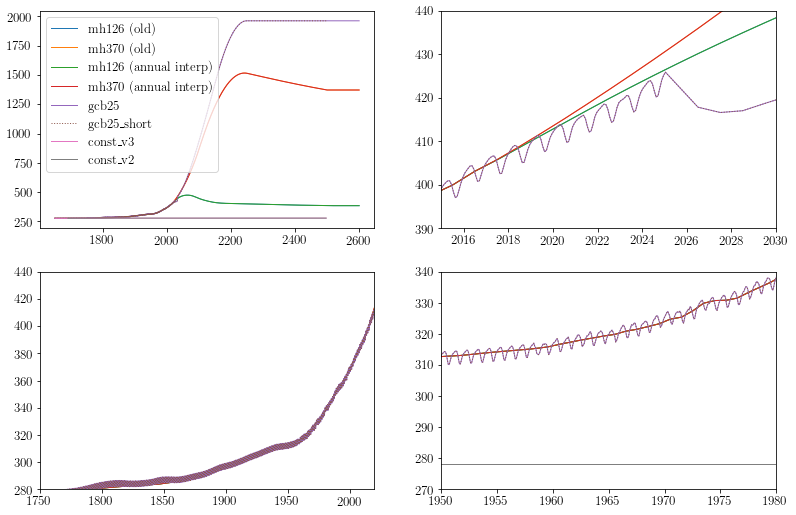

In [179]:
fact = 1.1
fig, axs = plt.subplots(2,2, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

dfs = [mh126, mh370, mh126_annual, mh370_annual,\
       gcb25, gcb25_short, const_v3, const_v2]
dfnames = ['mh126 (old)', 'mh370 (old)', 'mh126 (annual interp)', 'mh370 (annual interp)', \
           'gcb25', 'gcb25_short', 'const_v3', 'const_v2']

for i in range(0,4):
    for n in range(0, len(dfs)):

        dfname = dfnames[n]
        df = dfs[n]
        tl = '-'; linewidth = 1
        if dfname == 'gcb25_short': tl = ':'; linewidth = 1
        
        axs[i].plot(df.year, df.co2, label = f'{dfname}', linestyle = tl, linewidth = linewidth)

axs[0].legend(loc = 'best')
axs[1].set_xlim([2015,2030]); axs[1].set_ylim([390,440]);
axs[2].set_xlim([1750,2020]); axs[2].set_ylim([280,440]);
axs[3].set_xlim([1950,1980]); axs[3].set_ylim([270,340]);

In [168]:
const_co2 = gcb25.copy()
const_co2['co2'] = 278.0

## save our favourites to new folder

In [170]:
gcb25

atmdir = '/gpfs/data/greenocean/software/resources/ModelResources/AtmosCO2/'

save = True
if save:
    gcb25.to_csv(f"{atmdir}/atmco2_GCB2025_TJ.dat", 
                       sep="\t", 
                       index=False, 
                       header=False, 
                       float_format="%.6f")
    
    mh126_annual.to_csv(f"{atmdir}/atmco2_ssp1-26-meinshausen2020_TJ.dat", 
                       sep="\t", 
                       index=False, 
                       header=False, 
                       float_format="%.6f")
    
    mh370_annual.to_csv(f"{atmdir}/atmco2_ssp3-70-meinshausen2020_TJ.dat", 
                       sep="\t", 
                       index=False, 
                       header=False, 
                       float_format="%.6f")
    
    const_co2.to_csv(f"{atmdir}/atmco2_constant278_TJ.dat", 
                   sep="\t", 
                   index=False, 
                   header=False, 
                   float_format="%.6f")

In [172]:
mh126 = pd.read_csv(f"{atmdir}/atmco2_ssp1-26-meinshausen2020_TJ.dat",\
                    delim_whitespace=True, header=None, names=["year", "co2", "co2a", "que"])
mh370 = pd.read_csv(f"{atmdir}/atmco2_ssp3-70-meinshausen2020_TJ.dat",\
                    delim_whitespace=True, header=None, names=["year", "co2", "co2a", "que"])

gcb25 = pd.read_csv(f"{atmdir}/atmco2_GCB2025_TJ.dat", \
                    delim_whitespace=True, header=None, names=["year", "co2", "co2a", "que"])

const = pd.read_csv(f"{atmdir}/atmco2_constant278_TJ.dat", \
                      delim_whitespace=True, header=None, names=["year", "co2", "co2a", "que"])



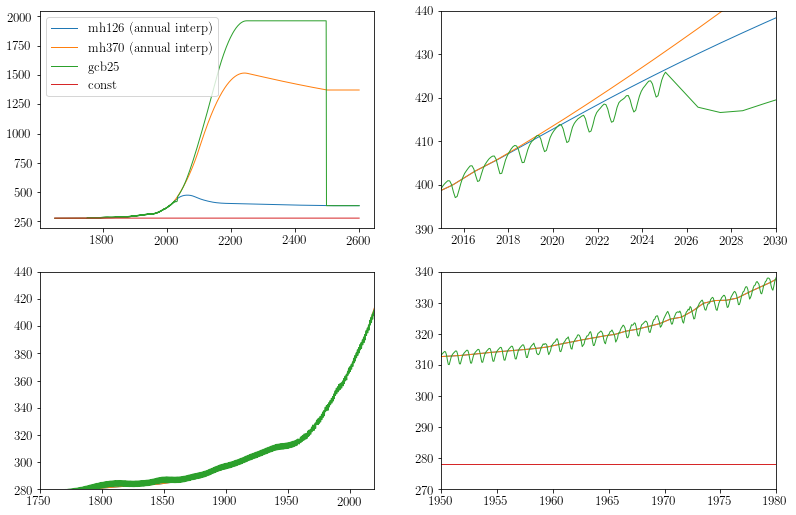

In [173]:
fact = 1.1
fig, axs = plt.subplots(2,2, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

dfs = [mh126, mh370, 
       gcb25, const]
dfnames = ['mh126 (annual interp)', 'mh370 (annual interp)', \
           'gcb25', 'const']

for i in range(0,4):
    for n in range(0, len(dfs)):

        dfname = dfnames[n]
        df = dfs[n]
        tl = '-'; linewidth = 1
        if dfname == 'gcb25_short': tl = ':'; linewidth = 1
        
        axs[i].plot(df.year, df.co2, label = f'{dfname}', linestyle = tl, linewidth = linewidth)

axs[0].legend(loc = 'best')
axs[1].set_xlim([2015,2030]); axs[1].set_ylim([390,440]);
axs[2].set_xlim([1750,2020]); axs[2].set_ylim([280,440]);
axs[3].set_xlim([1950,1980]); axs[3].set_ylim([270,340]);